# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

#from notebooks.utils import display, sample_batch

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 20
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Prepare the data <a name="prepare"></a>

In [ ]:
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/dataset.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall()

In [ ]:
train_data = utils.image_dataset_from_directory(
    "/content/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40065 files belonging to 1 classes.


In [ ]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [ ]:
train2 = train.take(5000)

In [ ]:
train_sample = sample_batch(train)

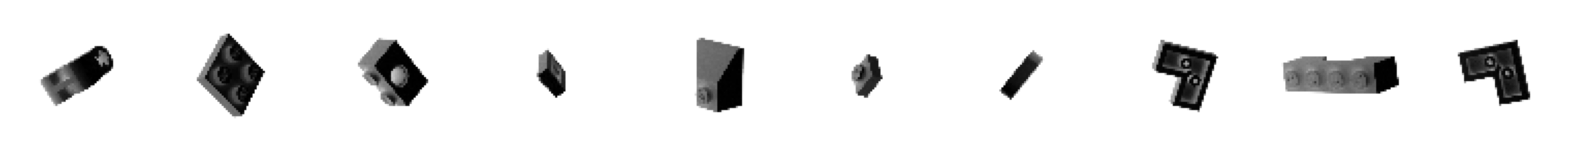

In [ ]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [ ]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_14 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                           

In [ ]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 4, 4, 512)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_17 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 8, 8, 256)         2097

In [ ]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [ ]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [ ]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/5
313/314 [============================>.] - ETA: 0s - d_loss: 0.2709 - d_real_acc: 0.8401 - d_fake_acc: 0.8533 - d_acc: 0.8467 - g_loss: 4.0743 - g_acc: 0.1467
Saved to ./output/generated_img_000.png


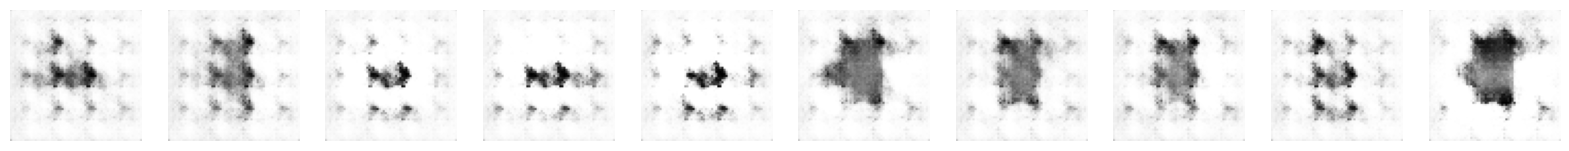

314/314 [==============================] - 94s 265ms/step - d_loss: 0.2752 - d_real_acc: 0.8401 - d_fake_acc: 0.8533 - d_acc: 0.8467 - g_loss: 4.0829 - g_acc: 0.1467
Epoch 2/5
313/314 [============================>.] - ETA: 0s - d_loss: 0.0602 - d_real_acc: 0.9016 - d_fake_acc: 0.9118 - d_acc: 0.9067 - g_loss: 4.6905 - g_acc: 0.0882
Saved to ./output/generated_img_001.png


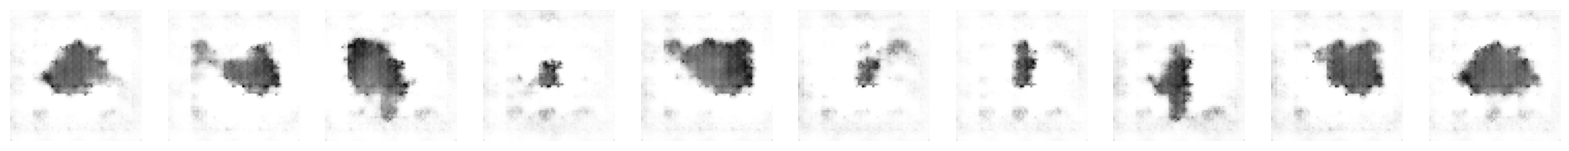

314/314 [==============================] - 82s 255ms/step - d_loss: 0.0624 - d_real_acc: 0.9016 - d_fake_acc: 0.9118 - d_acc: 0.9067 - g_loss: 4.6911 - g_acc: 0.0882
Epoch 3/5
313/314 [============================>.] - ETA: 0s - d_loss: 0.0714 - d_real_acc: 0.8919 - d_fake_acc: 0.8977 - d_acc: 0.8948 - g_loss: 4.7470 - g_acc: 0.1023
Saved to ./output/generated_img_002.png


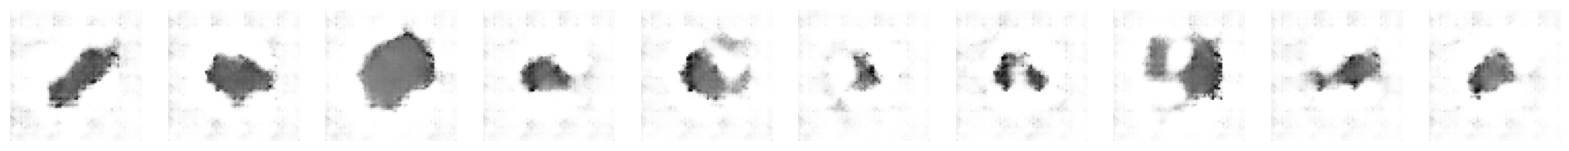

314/314 [==============================] - 93s 292ms/step - d_loss: 0.0814 - d_real_acc: 0.8919 - d_fake_acc: 0.8977 - d_acc: 0.8948 - g_loss: 4.7622 - g_acc: 0.1023
Epoch 4/5
313/314 [============================>.] - ETA: 0s - d_loss: 0.0953 - d_real_acc: 0.8874 - d_fake_acc: 0.8874 - d_acc: 0.8874 - g_loss: 4.5865 - g_acc: 0.1126
Saved to ./output/generated_img_003.png


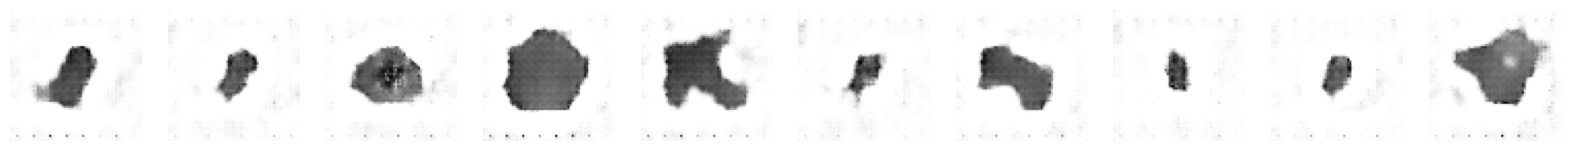

314/314 [==============================] - 87s 273ms/step - d_loss: 0.1085 - d_real_acc: 0.8873 - d_fake_acc: 0.8874 - d_acc: 0.8874 - g_loss: 4.5752 - g_acc: 0.1126
Epoch 5/5
313/314 [============================>.] - ETA: 0s - d_loss: 0.1391 - d_real_acc: 0.8792 - d_fake_acc: 0.8752 - d_acc: 0.8772 - g_loss: 4.0569 - g_acc: 0.1248
Saved to ./output/generated_img_004.png


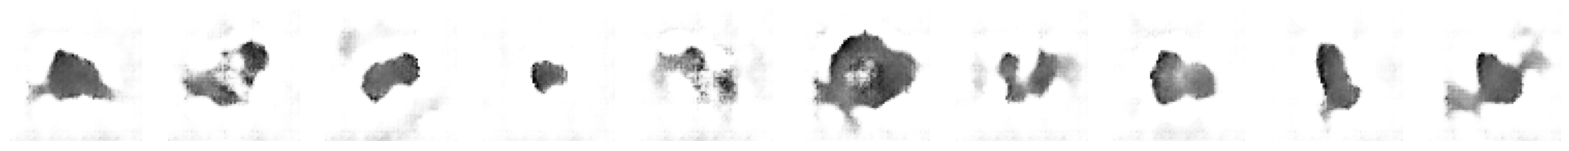

314/314 [==============================] - 82s 257ms/step - d_loss: 0.1437 - d_real_acc: 0.8791 - d_fake_acc: 0.8753 - d_acc: 0.8772 - g_loss: 4.0802 - g_acc: 0.1247


In [ ]:
dcgan.fit(
    train2,
    epochs=5, #EPOCHS
    callbacks=[
        #model_checkpoint_callback,
        #tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 618ms/step


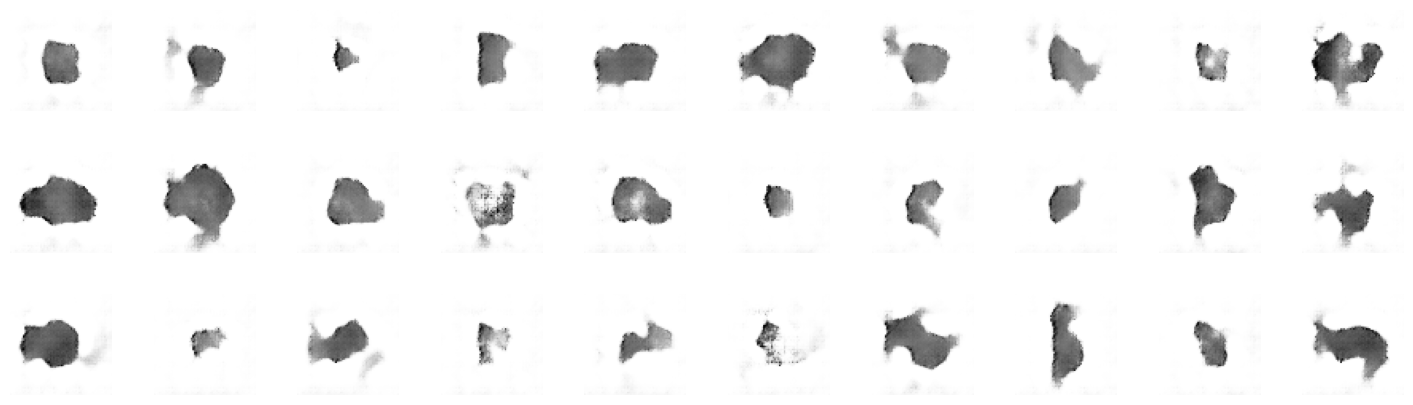

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train2.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

KeyboardInterrupt: ignored

Exception ignored in: <function _xla_gc_callback at 0x7d419f6091b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 472ms/step


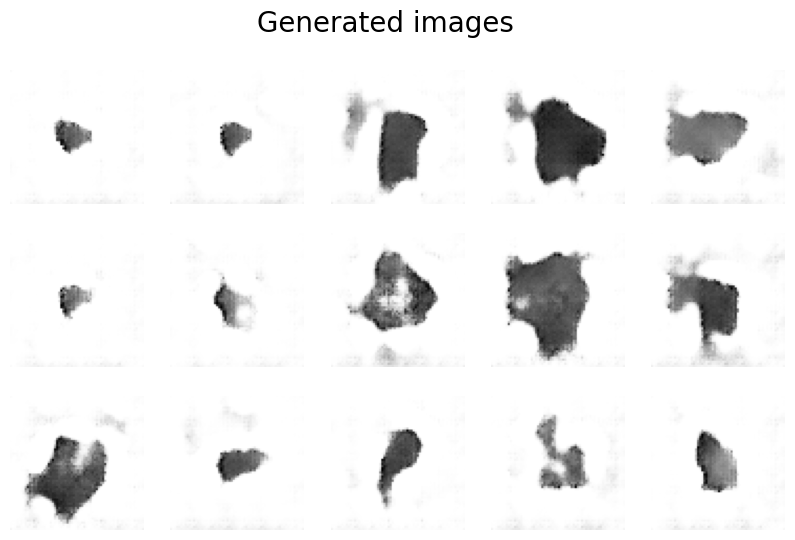

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

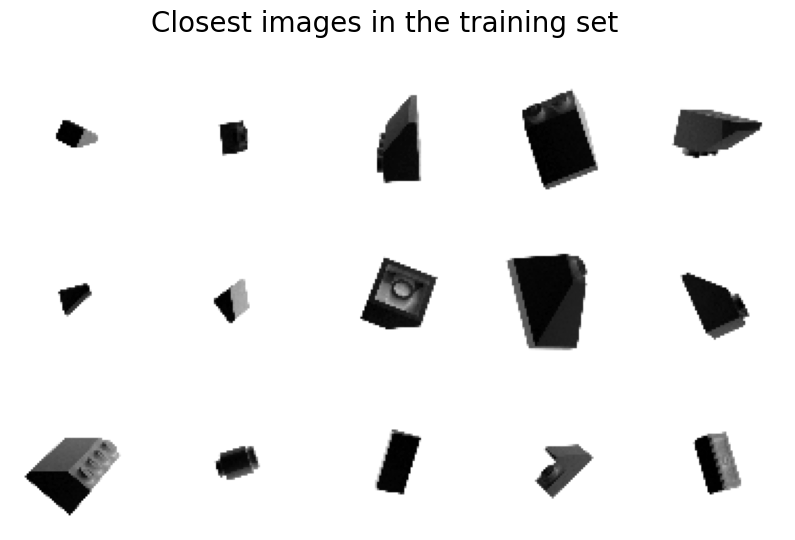

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()